#1.에일리언 vs 프레데터 데이터셋
https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

* 데이터셋 받기전 토큰 발급받기 : 캐글 로그인 -> 계정클릭 -> Your Profile -> Account -> 밑쪽에 API부분에 Create New Token 클릭 -> Json파일 다운로드 받기

* 토큰값
{"username":"sangdal","key":"ab588b3d941bfbd1bb020a3e779368ed"}

In [ ]:
# 캐글에서 바로 데이터셋 가져오기
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] ='sangdal' # username
os.environ['KAGGLE_KEY'] = 'ab588b3d941bfbd1bb020a3e779368ed' # key

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

 92% 13.0M/14.1M [00:01<00:00, 15.1MB/s]
100% 14.1M/14.1M [00:01<00:00, 8.89MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
# GPU사용하기
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#2.이미지 증강 기법(Image Augmentation)
* 원본 데이터(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
  * 일반적으로 모델 성능이 좋아진다.
  * Over Fitting 방지

* https://pytorch.org/vision/master/transforms.html

In [ ]:
data_transforms = {
    'train' : transforms.Compose([                              # Compose 아래 내용을 한꺼번에 실행시켜라
        transforms.Resize((224,224)),                           # 224,224사이즈로 변경 하기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # 랜덤하게 10개를 뽑아서 규모는 +-20%
        transforms.RandomHorizontalFlip(),                      # 이미지 반전시킴
        transforms.ToTensor()                                   # 텐서 형태로 바꿔라
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
# 데이터셋 만들기
image_datasets = {
    'train' : datasets.ImageFolder('data/train', data_transforms['train'], target_transform = target_transforms),
    'validation' : datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform = target_transforms)
}

dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'validation' : DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle = False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


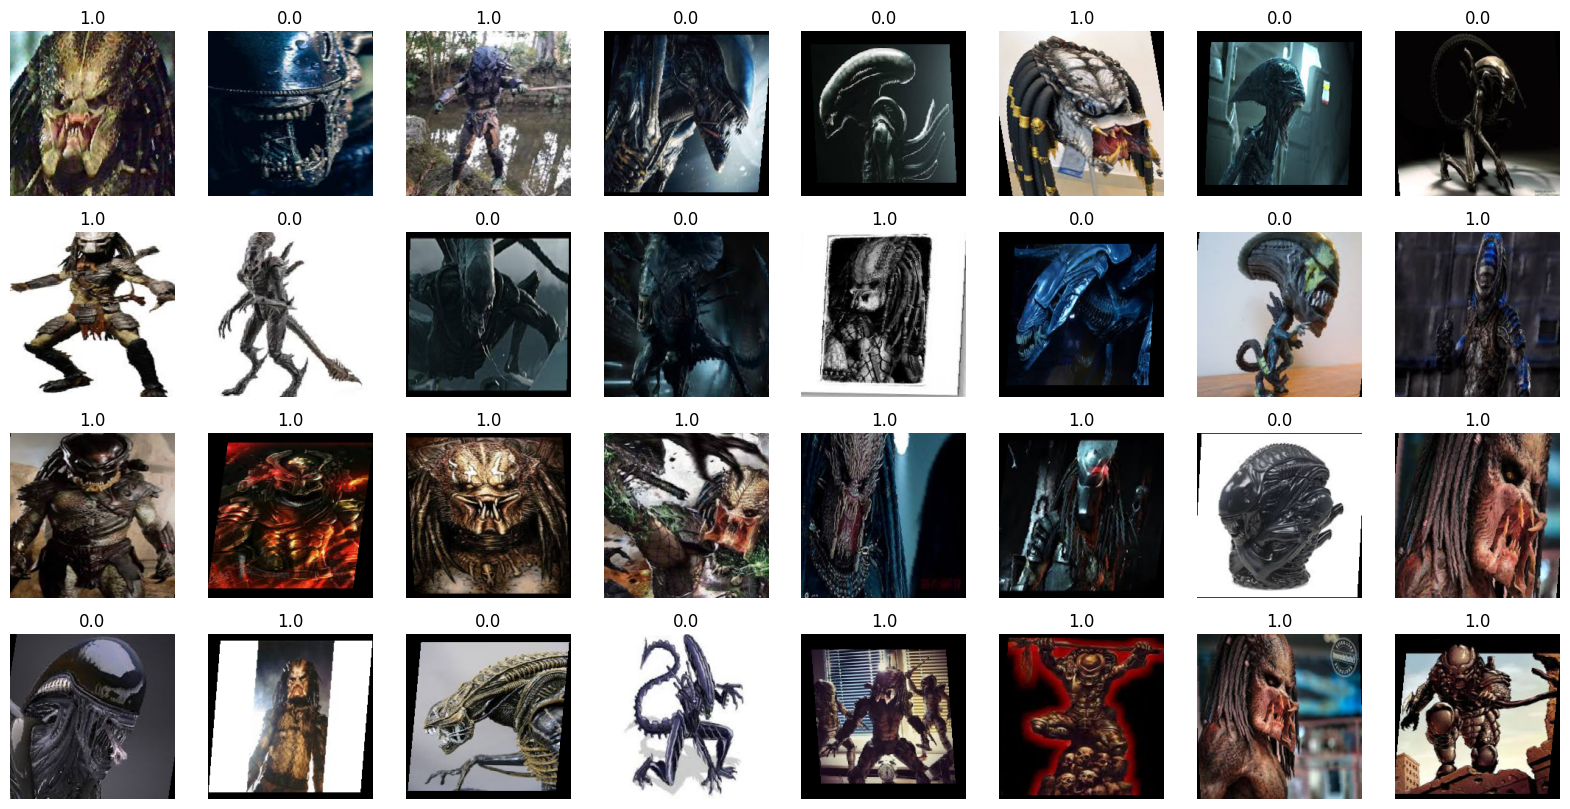

In [ ]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4,8,figsize=(20,10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))
  ax.axis('off')

#3.전이학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행모델의 시작점으로 활용하는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편하다.
* 전이 학습은 여러 응용 분야 중에서도 특히 검출, 영상인식, 음성인식, 검색 분야에 많이 사용된다.

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

###3-1.전이 학습의 고려할 점
* 크기: 모델크기의 중요성은 모델을 배포할 위치와 방법에 따라 달라진다.
* 정확도: 재훈련 전의 모델 성능은 어느 정도인지 확인이 필요하다.
* 예측속도: 하드웨어 및 배치 크기와 같은 다른 딥러닝 요소는 물론 선택된 모델의 아키텍쳐와 모델크기에 따라서도 달라진다.

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

#4.사전 학습된 ResNet50 모델 사용해보기
* [파이토치에서 제공되는 모델들](https://pytorch.org/vision/stable/models.html)
![](https://i.stack.imgur.com/gI4zT.png)

###4-1.이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 동물과 사물 이미지를 포함하고 있는 데이터베이스

![](https://i.imgur.com/5Rz5s8e.png)

In [ ]:
# model = models.resnet50(pretrained =  True).to(device)
# pretrained =  True (전이학습을 하겠다.)
# pretrained =  False (전이학습을 하지 않겠다.)

# IMAGENET1k_V1 :대소문자 유의
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)
print(model)

###4-2.Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정한다.
* 출력부분의 레이어(fc)를 다시 설정하여 분류에 맞게 설정한다.

In [ ]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'trani':
      model.train() # 메모리에 옵티마이저가 돌아갈 메모리를 할당해준다.
    else:
      model.eval() # 옵티마이저 돌아갈 메모리를 지워버리고 테스트를 하기때문에 메모리가 절약되어 속도가빠름


    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])


    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.6140, Accuracy: 61.39%
validation: Epoch    1/10, Loss: 0.4290, Accuracy: 89.29%
train     : Epoch    2/10, Loss: 0.3429, Accuracy: 89.71%
validation: Epoch    2/10, Loss: 0.3218, Accuracy: 87.95%
train     : Epoch    3/10, Loss: 0.2611, Accuracy: 90.78%
validation: Epoch    3/10, Loss: 0.2642, Accuracy: 90.18%
train     : Epoch    4/10, Loss: 0.1992, Accuracy: 92.56%
validation: Epoch    4/10, Loss: 0.2517, Accuracy: 90.18%
train     : Epoch    5/10, Loss: 0.1901, Accuracy: 92.69%
validation: Epoch    5/10, Loss: 0.2516, Accuracy: 90.18%
train     : Epoch    6/10, Loss: 0.1707, Accuracy: 93.32%
validation: Epoch    6/10, Loss: 0.3242, Accuracy: 86.61%
train     : Epoch    7/10, Loss: 0.1506, Accuracy: 94.12%
validation: Epoch    7/10, Loss: 0.2724, Accuracy: 89.29%
train     : Epoch    8/10, Loss: 0.1367, Accuracy: 95.96%
validation: Epoch    8/10, Loss: 0.2537, Accuracy: 90.18%
train     : Epoch    9/10, Loss: 0.1283, Accuracy: 95.96%
validation: Ep

In [ ]:
# 학습한거 배포하기

torch.save(model.state_dict(), 'model.h5')

In [ ]:
# 배포된 모델 불러와보기

model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)


train     : Epoch    1/10, Loss: 2.1758, Accuracy: 49.94%
validation: Epoch    1/10, Loss: 0.6967, Accuracy: 44.64%


KeyboardInterrupt: ignored

In [ ]:

# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train() # 메모리에 옵티마이저가 돌아갈 메모리를 할당해준다.
    else:
      model.eval() # 옵티마이저 돌아갈 메모리를 지워버리고 테스트를 하기때문에 메모리가 절약되어 속도가빠름


    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])


    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

In [ ]:
# 모델 로드하기
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'trani':
      model.train() # 메모리에 옵티마이저가 돌아갈 메모리를 할당해준다.
    else:
      model.eval() # 옵티마이저 돌아갈 메모리를 지워버리고 테스트를 하기때문에 메모리가 절약되어 속도가빠름


    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])


    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1597, Accuracy: 93.18%
validation: Epoch    1/10, Loss: 0.2540, Accuracy: 90.18%
train     : Epoch    2/10, Loss: 0.1166, Accuracy: 95.88%
validation: Epoch    2/10, Loss: 0.2509, Accuracy: 90.62%
train     : Epoch    3/10, Loss: 0.0944, Accuracy: 96.53%
validation: Epoch    3/10, Loss: 0.2583, Accuracy: 90.18%
train     : Epoch    4/10, Loss: 0.1045, Accuracy: 96.02%
validation: Epoch    4/10, Loss: 0.2718, Accuracy: 87.95%
train     : Epoch    5/10, Loss: 0.0958, Accuracy: 95.96%
validation: Epoch    5/10, Loss: 0.2500, Accuracy: 91.52%
train     : Epoch    6/10, Loss: 0.0938, Accuracy: 96.88%
validation: Epoch    6/10, Loss: 0.2603, Accuracy: 90.62%
train     : Epoch    7/10, Loss: 0.0886, Accuracy: 96.46%
validation: Epoch    7/10, Loss: 0.2657, Accuracy: 90.18%
train     : Epoch    8/10, Loss: 0.0760, Accuracy: 96.88%
validation: Epoch    8/10, Loss: 0.2524, Accuracy: 91.52%
train     : Epoch    9/10, Loss: 0.0791, Accuracy: 97.44%
validation: Ep

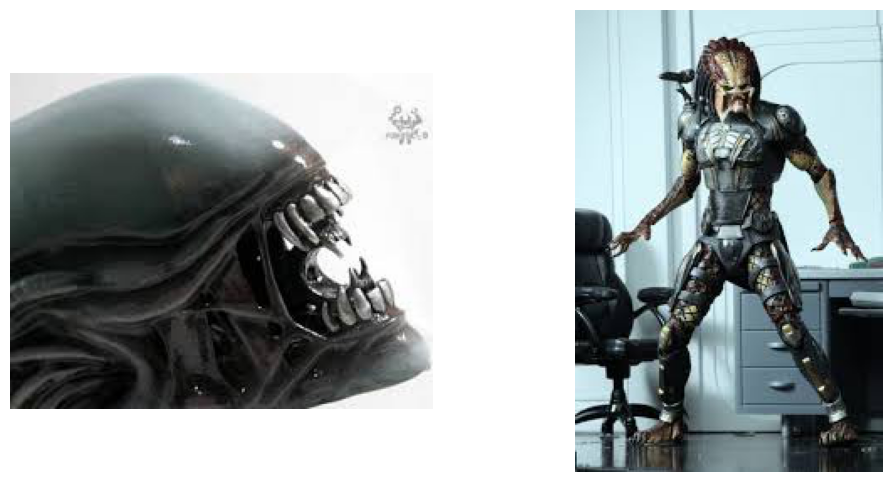

In [ ]:
# 테스트 해보기
from PIL import Image

# 학습용(train)말고  validation안에 있는 이미지를 사용한다.
img1 = Image.open('data/validation/alien/32.jpg')
img2 = Image.open('data/validation/predator/45.jpg')

# 어떤 사진인지 확인해보기(안해도 상관은 없음)
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
# 테스트를 위해 사이즈 변경하기
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
# 이미지 두개 붙이기
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
# 예측해보기
y_pred = model(test_batch)
y_pred

tensor([[0.0254],
        [0.9212]], device='cuda:0', grad_fn=<SigmoidBackward0>)

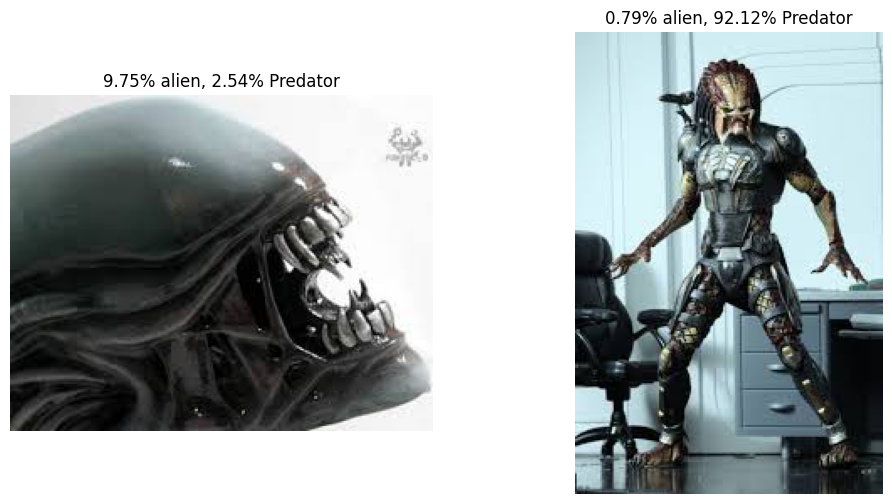

In [ ]:
# 에일리언 , 프레데터  사진 img1,img2 테스트 해보기
fig, axes = plt.subplots(1,2,figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0])*100:.2f}% alien, {y_pred[0,0] * 100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0])*100:.2f}% alien, {y_pred[1,0] * 100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* 캐글데이터셋 : https://www.kaggle.com/c/dogs-vs-cats
